# Feature Engineering

In [1]:
import pandas as pd
from pandasql import sqldf
import numpy as np

In [2]:
data = pd.read_csv("../data/For Students-Updated2022-03-25/data files/logs.csv")

/tmp/ipykernel_105000/2077613250.py:1: DtypeWarning: Columns (34,38,39,40,47,50,53,54,57,58,59,60,62,68,70,72,73,74,76,77,78,81,85,88,89,90,91,92,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,118,120,121,122,123,129,131) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/For Students-Updated2022-03-25/data files/logs.csv")


In [3]:
swear_words = list(pd.read_csv("../data/external/bad_words.csv").en_bad_words)

In [4]:
# Idling Calculations
def idle_time(data, idle_period=60):
    idle_time = 0
    idle_instances = 0
    for i, x in data.iterrows():
        if i!=0:
            diff=x.event_time_dbl-data.iloc[i-1].event_time_dbl
            if diff>idle_period:
                idle_time+=diff
                idle_instances+=1
    return (idle_time, idle_instances)

def full_idle(data, idle_period=60):
    results = {
        'player_id':[],
        f'idle_time_{idle_period}':[],
        f'idle_count_{idle_period}':[]
    }
    
    temp = data.copy()
    temp.reset_index(inplace=True)
    results['player_id'].append(temp.player_id.unique()[0])
    time, instance = idle_time(temp, idle_period=idle_period)
    results[f'idle_time_{idle_period}'].append(time)
    results[f'idle_count_{idle_period}'].append(instance)
    
    return pd.DataFrame(results)

def count_events(data):
    return pd.DataFrame({"player_id":list(data.player_id)[0],"total_events":[data.shape[0]]})

def total_time(data):
    init_time = list(data["event_time_dbl"])[0]
    end_time = list(data["event_time_dbl"])[-1]
    return pd.DataFrame({"player_id":list(data.player_id)[0],"total_time":[end_time-init_time]})

def used_profanity(data):
    profanity_count = 0
    profanity = ""
    for i in " ".join(list(data.new_label.dropna().unique())).split(" "):
        if(i in swear_words):
            profanity_count += 1
            profanity += i + ", "
    if(profanity != ""):
        profanity = profanity[:-2]
    return pd.DataFrame({"player_id":list(data.player_id)[0], "profanity_uses":[profanity_count], "profane_text":[profanity if profanity != "" else np.nan]})

def get_quit_count(data):
    num_quits = data[data["event_id"] == 1002].shape[0]
    if(not num_quits <= 0 or type(num_quits) != type(int)):
        num_quits = 0
    return pd.DataFrame({"player_id":list(data.player_id)[0],"total_quits":[num_quits]})

def get_labels(data):
    available_labels = ['020', '820', '350', '430', '121', '021', '521', 
                '320', '300', '830', '630', '810', '120', '011', 
                '010', '420', '640', '210', '110', '840', '022', 
                '111', '520', '200', '540']
    appeared_labels = []
    filled_labels = []
    
    for i in available_labels:
        for index, row in data[(data["aa_level_id"] == int(i[0]))&(data["chunk_id"] == int(i[1]))&(data["piece_id"] == int(i[0]))].iterrows():
            if(i not in filled_labels and row["new_label"] is not np.nan):
                if(i not in appeared_labels):
                    appeared_labels.append(i)
                filled_labels.append(i)
            elif(i not in appeared_labels and row["new_label"] is np.nan):
                appeared_labels.append(i)
    if(len(appeared_labels) == 0):
        prop = 1
    else:
        prop = len(filled_labels)/len(appeared_labels)
    return pd.DataFrame({"player_id":list(data.player_id)[0],"label_filled_count":[len(filled_labels)],"proportion_filled_labels":[prop]})

def get_minigames_completed(data):
    completed = 0
    total_done = data[(data["event_id"] == 1001)].shape[0]
    total_restart = data[(data["event_id"] == 1000)].shape[0]
    return pd.DataFrame({"player_id":list(data.player_id)[0],"total_minigames_done_btn":[total_done],"total_restarts":[total_restart]})

def total_stars_earned(data):
    player_ids = data.player_id.unique()
    results = {'player_id':[],'total_stars':[]}
    data = data[data.event_id == 1005]
    for p_id in player_ids:
        temp_data = data[data.player_id==p_id]
        stars = 0
        for i, x in data.iterrows():
            stars += x.new_skill_point - x.old_skill_point
        results['player_id'].append(p_id)
        results['total_stars'].append(stars)
    return pd.DataFrame(results)

def unique_minigames_completed(sessions):
    completed_minigames = set()
    new = {}
    for s in sessions:
        this_set = set()
        data = sessions[s][(sessions[s].event_id==1001)|(sessions[s].event_id==1003)].reset_index(drop=True)
        last_id = -1
        for i, x in data.iterrows():
            if x.event_id == 1003:
                last_id = x.minigame_id
            elif x.event_id == 1001:
                this_set.add((last_id, x.minigame_level))
        try:
            pid = list(data.iloc[0].player_id)[0]
        except:
            pid = np.nan
        new[s] = pd.DataFrame({
            'player_id': [pid],
            'new_minigames_completed': [len(this_set-completed_minigames)]
        })
        completed_minigames = completed_minigames.union(this_set)
    return new

In [5]:
data = data[data["player_id"] == list(data.player_id)[0]]
players = {x:[] for x in data.player_id.unique()}
for i,player in enumerate(data.player_id.unique()):
    p_subset = data[data["player_id"] == player]
    sessions = {x:[] for x in p_subset.session.unique()}
    for session in p_subset.session.unique():

        s_subset = p_subset[p_subset["session"] == session]

        full_sub = s_subset.copy()

        s_idle = full_idle(s_subset, idle_period=60)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_idle ON full_sub.player_id = s_idle.player_id")
        s_idle = full_idle(s_subset, idle_period=300)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_idle ON full_sub.player_id = s_idle.player_id")
        s_event_count = count_events(s_subset)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_event_count ON full_sub.player_id = s_event_count.player_id")
        s_total_time = total_time(s_subset)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_total_time ON full_sub.player_id = s_total_time.player_id")
        s_profanity = used_profanity(s_subset)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_profanity ON full_sub.player_id = s_profanity.player_id")
        s_quit = get_quit_count(s_subset)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_quit ON full_sub.player_id = s_quit.player_id")
        s_labels = get_labels(s_subset)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_labels ON full_sub.player_id = s_labels.player_id")
        s_minigames = get_minigames_completed(s_subset)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_minigames ON full_sub.player_id = s_minigames.player_id")
        s_stars = total_stars_earned(s_subset)
        full_sub = sqldf("SELECT * FROM full_sub INNER JOIN s_stars ON full_sub.player_id = s_stars.player_id")
        
        for col in ["idle_time_60","idle_count_60","idle_time_300","idle_count_300","total_stars","new_minigames_completed","total_minigames_done_btn","total_quits","total_restarts","proportion_filled_labels","total_events","profanity_uses"]:
            if(col not in full_sub.columns):
                    full_sub[col] = 0

        print(session)

        sessions[session] = full_sub
    p_session_mgs = unique_minigames_completed(sessions)
    for i in p_session_mgs:
        session_df = sessions[i].T.drop_duplicates().T
        #print(session_df)
        session_mgs_df = p_session_mgs[i].T.drop_duplicates().T
        #print(session_mgs_df.player_id)
        #print(session_mgs_df.unique_minigames_completed)
        sessions[i] = sqldf("SELECT * FROM session_df INNER JOIN session_mgs_df ON session_df.player_id = session_mgs_df.player_id")
    players[player] = sessions
#players

Session 1
Session 2
Session 3
Session 4
Session 5
Session 6
Session 7
Session 8
Session 9
Session 10
Session 11


# Report Generation

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
features = [
    "idle_time_60", 
    "idle_count_60", 
    "idle_time_300", 
    "idle_count_300", 
    "total_stars",
    "total_minigames_completed",
    "new_minigames_completed",
    "total_events",
    "total_time",
    "profanity_uses",
    "total_quits", 
    "total_restarts",
    "proportion_filled_labels"
]

additional = ["profane_text"]

In [8]:
def string_report(data):
    player_session_data = data.copy()
    for session in player_session_data:
        p = player_session_data[session]
        player_session_data[session] = sqldf("SELECT * FROM p LIMIT 1")
        for col in ["idle_time_60","idle_count_60","idle_time_300","idle_count_300","total_stars","new_minigames_completed","total_minigames_done_btn","total_quits","total_restarts","proportion_filled_labels","total_events","profanity_uses"]:
            if(col not in player_session_data[session].columns):
                    player_session_data[session][col] = 0
        if("profane_text" not in player_session_data[session].columns):
            player_session_data[session]["profane_text"] = ""
        player_session_data[session] = pd.Series(player_session_data[session].iloc[0])
    recent_keys = sorted(list(player_session_data.keys()), key=lambda x: x.strip()[-1], reverse=True)
    present = recent_keys[0]
    previous = recent_keys[1]
    return f"""Last Session
============
Idle time (1 min): {np.round_(player_session_data[previous].idle_time_60/60)}
Idle count (1 min): {np.round_(player_session_data[previous].idle_count_60/60)}
Idle time (5 min): {np.round_(player_session_data[previous].idle_time_300/60)}
Idle count (5 min): {np.round_(player_session_data[previous].idle_count_300/60)}
Stars earned: {np.round_(player_session_data[previous].total_stars)}
New minigames completed: {np.round_(player_session_data[previous].new_minigames_completed)}
Total minigames completed: {np.round_(player_session_data[previous].total_minigames_done_btn)}
Minigame quits: {np.round_(player_session_data[previous].total_quits)}
Minigame restarts: {np.round_(player_session_data[previous].total_restarts)}
Label filled proportion: {np.round_(player_session_data[previous].proportion_filled_labels)}
Total events: {np.round_(player_session_data[previous].total_events)}
Number of profane words used: {player_session_data[previous].profanity_uses}
Profane text: {player_session_data[previous].profane_text}

This Session
============
Idle time (1 min): {np.round_(player_session_data[present].idle_time_60/60)} minutes, {np.round_(player_session_data[present].idle_count_60)} instances
    Percent change time: {np.round_(100*(player_session_data[present].idle_time_60-player_session_data[previous].idle_time_60)/max(player_session_data[previous].idle_time_60,.00001))}%
    Percent change instances: {np.round_(100*(player_session_data[present].idle_count_60-player_session_data[previous].idle_count_60)/max(player_session_data[previous].idle_count_60,.00001))}%
Idle time (5 min): {np.round_(player_session_data[present].idle_time_300/60)} minutes, {np.round_(player_session_data[present].idle_count_300)} instances
    Percent change time: {np.round_(100*(player_session_data[present].idle_time_300-player_session_data[previous].idle_time_300)/max(player_session_data[previous].idle_time_300,.00001))}%
    Percent change instances: {np.round_(100*(player_session_data[present].idle_count_300-player_session_data[previous].idle_count_300)/max(player_session_data[previous].idle_count_300,.00001))}%
Stars earned: {np.round_(player_session_data[present].total_stars)}
    Percent change: {np.round_(100*(player_session_data[present].total_stars-player_session_data[previous].total_stars)/max(player_session_data[previous].total_stars,.00001))}%
New minigames completed: {np.round_(player_session_data[present].new_minigames_completed)}
    Percent change: {np.round_(100*(player_session_data[present].new_minigames_completed-player_session_data[previous].new_minigames_completed)/max(player_session_data[previous].new_minigames_completed,.00001))}%
Minigame quits: {np.round_(player_session_data[present].total_quits)}
    Percent change: {np.round_(100*(player_session_data[present].total_quits-player_session_data[previous].total_quits)/max(player_session_data[previous].total_quits,.00001))}%
Minigame restarts: {player_session_data[present].total_restarts}
    Percent change: {np.round_(100*(player_session_data[present].total_restarts-player_session_data[previous].total_restarts)/max(player_session_data[previous].total_restarts,.00001))}%
Label filled proportion: {np.round_(player_session_data[present].proportion_filled_labels)}
    Percent change: {np.round_(100*(player_session_data[present].proportion_filled_labels-player_session_data[previous].proportion_filled_labels)/max(player_session_data[previous].proportion_filled_labels,.00001))}%
Total events: {np.round_(player_session_data[present].total_events)}
    Percent change: {np.round_(100*(player_session_data[present].total_events-player_session_data[previous].total_events)/max(player_session_data[previous].total_events,.00001))}%
Profanity used: {player_session_data[present].profanity_uses}
    Percent change: {np.round_(100*(player_session_data[present].profanity_uses-player_session_data[previous].profanity_uses)/max(player_session_data[previous].profanity_uses,.00001))}%
    Previous profane text: {player_session_data[previous].profane_text}
"""

In [9]:
def string_report_2(data):
    player_session_data = data.copy()
    for session in player_session_data:
        p = player_session_data[session]
        player_session_data[session] = sqldf("SELECT * FROM p LIMIT 1")
        for col in ["idle_time_60","idle_count_60","idle_time_300","idle_count_300","total_stars","new_minigames_completed","total_minigames_done_btn","total_quits","total_restarts","proportion_filled_labels","total_events","profanity_uses"]:
            if(col not in player_session_data[session].columns):
                    player_session_data[session][col] = 0
        if("profane_text" not in player_session_data[session].columns):
            player_session_data[session]["profane_text"] = ""
        player_session_data[session] = pd.Series(player_session_data[session].iloc[0])
    recent_keys = sorted(list(player_session_data.keys()), key=lambda x: x.strip()[-1], reverse=True)
    present = recent_keys[0]
    previous = recent_keys[1]
   
    result_string = "Last Session\n============\n"
    try:
        result_string += f"Idle time (1 min): {np.round_(player_session_data[previous]['idle_time_60'])}\n"
    except AttributeError:
        result_string += f"Idle time (1 min): N/A\n"
    try:
        result_string += f"Idle count (1 min): {np.round_(player_session_data[previous]['idle_count_60'])}\n"
    except AttributeError:
        result_string += f"Idle count (1 min): N/A\n"
    try:
        result_string += f"Idle time (5 min): {np.round_(player_session_data[previous]['idle_time_300'])}\n"
    except AttributeError:
        result_string += f"Idle time (5 min): N/A\n"
    try:
        result_string += f"Idle count (5 min): {np.round_(player_session_data[previous]['idle_count_300'])}\n"
    except AttributeError:
        result_string += f"Idle count (5 min): N/A\n"
    try:
        result_string += f"Stars earned: {np.round_(player_session_data[previous]['total_stars'])}\n"
    except AttributeError:
        result_string += f"Stars earned: N/A\n"
    try:
        result_string += f"New minigames completed: {np.round_(player_session_data[previous]['new_minigames_completed'])}\n"
    except AttributeError:
        result_string += f"New minigames completed: N/A\n"
    try:
        result_string += f"Total minigames completed: {np.round_(player_session_data[previous]['total_minigames_done_btn'])}\n"
    except AttributeError:
        result_string += f"Total minigames completed: N/A\n"
    try:
        result_string += f"Minigame quits: {np.round_(player_session_data[previous]['total_quits'])}\n"
    except AttributeError:
        result_string += f"Minigame quits: N/A\n"
    try:
        result_string += f"Minigame restarts: {np.round_(player_session_data[previous]['total_restarts'])}\n"
    except AttributeError:
        result_string += f"Minigame restarts: N/A\n"
    try:
        result_string += f"Label filled proportion: {np.round_(player_session_data[previous]['proportion_filled_labels'])}\n"
    except AttributeError:
        result_string += f"Label filled proportion: N/A\n"
    try:
        result_string += f"Total events: {np.round_(player_session_data[previous]['total_events'])}\n"
    except AttributeError:
        result_string += f"Total events: N/A\n"
    try:
        result_string += f"Number of profane words used: {player_session_data[previous]['profanity_uses']}\n"
    except AttributeError:
        result_string += f"Number of profane words used: N/A\n"
    try:
        result_string += f"Profane text: {player_session_data[previous]['profane_text']}\n"
    except AttributeError:
        result_string += f"Profane text: N/A\n"
    result_string += "This Session\n============\n"
    try:
        result_string += f"Idle time (1 min): {np.round_(player_session_data[present]['idle_time_60'])} minutes, {np.round_(player_session_data[present]['idle_count_60'])} instances\n"
    except AttributeError:
        result_string += f"Idle time (1 min): N/A\n"
    try:
        result_string += f"\tPercent change time: {np.round_(100*(player_session_data[present]['idle_time_60'][0]-player_session_data[previous]['idle_time_60'])/max(player_session_data[previous]['idle_time_60'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change time: N/A\n"
    try:
        result_string += f"\tPercent change instances: {np.round_(100*(player_session_data[present]['idle_count_60']-player_session_data[previous]['idle_count_60'])/max(player_session_data[previous]['idle_count_60'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change instances: N/A\n"
    try:
        result_string += f"Idle time (5 min): {np.round_(player_session_data[present]['idle_time_300'])} minutes, {np.round_(player_session_data[present]['idle_count_300'])} instances\n"
    except AttributeError:
        result_string += f"Idle time (5 min): N/A\n"
    try:
        result_string += f"\tPercent change time: {np.round_(100*(player_session_data[present]['idle_time_300']-player_session_data[previous]['idle_time_300'])/max(player_session_data[previous]['idle_time_300'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change time: N/A\n"
    try:
        result_string += f"\tPercent change instances: {np.round_(100*(player_session_data[present]['idle_count_300']-player_session_data[previous]['idle_count_300'])/max(player_session_data[previous]['idle_count_300'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change instances: N/A\n"
    try:
        result_string += f"Stars earned: {np.round_(player_session_data[present]['total_stars'])}\n"
    except AttributeError:
        result_string += f"Stars earned: N/A\n"
    try:
        result_string += f"\tPercent change: {np.round_(100*(player_session_data[present]['total_stars']-player_session_data[previous]['total_stars'])/max(player_session_data[previous]['stars_by_total_stars'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change: N/A\n"
    try:
        result_string += f"New minigames completed: {np.round_(player_session_data[present]['new_minigames_completed'])}\n"
    except AttributeError:
        result_string += f"New minigames completed: N/A\n"
    try:
        result_string += f"\tPercent change: {np.round_(100*(player_session_data[present]['new_minigames_completed']-player_session_data[previous]['new_minigames_completed'])/max(player_session_data[previous]['new_minigames_completed'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change: N/A\n"
    try:
        result_string += f"Minigame quits: {np.round_(player_session_data[present]['total_quits'])}\n"
    except AttributeError:
        result_string += f"Minigame quits: N/A\n"
    try:
        result_string += f"\tPercent change: {np.round_(100*(player_session_data[present]['total_quits']-player_session_data[previous]['total_quits'])/max(player_session_data[previous]['total_quits'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change: N/A\n"
    try:
        result_string += f"Minigame restarts: {player_session_data[present]['total_restarts']}\n"
    except AttributeError:
        result_string += f"Minigame restarts: N/A\n"
    try:
        result_string += f"\tPercent change: {np.round_(100*(player_session_data[present]['total_restarts']-player_session_data[previous]['total_restarts'])/max(player_session_data[previous]['total_restarts'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change: N/A\n"
    try:
        result_string += f"Label filled proportion: {np.round_(player_session_data[present]['proportion_filled_labels'])}\n"
    except AttributeError:
        result_string += f"Label filled proportion: N/A\n"
    try:
        result_string += f"\tPercent change: {np.round_(100*(player_session_data[present]['proportion_filled_labels']-player_session_data[previous]['proportion_filled_labels'])/max(player_session_data[previous]['proportion_filled_labels'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change: N/A\n"
    try:
        result_string += f"Total events: {np.round_(player_session_data[present]['total_events'])}, {np.round_(player_session_data[present]['events_in_session'])} per minute\n"
    except AttributeError:
        result_string += f"Total events: N/A\n"
    try:
        result_string += f"\tPercent change: {np.round_(100*(player_session_data[present]['total_events']-player_session_data[previous]['total_events'])/max(player_session_data[previous]['total_events'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change: N/A\n"
    try:
        result_string += f"Profanity used: {player_session_data[present]['profanity_uses']}\n"
    except AttributeError:
        result_string += f"Profanity used: N/A\n"
    try:
        result_string += f"\tPercent change: {np.round_(100*(player_session_data[present]['profanity_uses']-player_session_data[previous]['profanity_uses'])/max(player_session_data[previous]['profanity_uses'],.00001))}%\n"
    except AttributeError:
        result_string += f"\tPercent change: N/A\n"
    try:
        result_string += f"\tPrevious profane text: {player_session_data[previous]['profane_text']}%\n"
    except AttributeError:
        result_string += f"\tPrevious profane text: N/A\n"
       
    return result_string


In [10]:
def plots(data):
    player_session_data = data.copy()
    for session in player_session_data:
        p = player_session_data[session]
        player_session_data[session] = sqldf("SELECT * FROM p LIMIT 1")
        for col in ["idle_time_60","idle_count_60","idle_time_300","idle_count_300","total_stars","new_minigames_completed","total_minigames_done_btn","total_quits","total_restarts","proportion_filled_labels","total_events","profanity_uses"]:
            if(col not in player_session_data[session].columns):
                    player_session_data[session][col] = 0
        if("profane_text" not in player_session_data[session].columns):
            player_session_data[session]["profane_text"] = ""
        player_session_data[session] = pd.Series(player_session_data[session].iloc[0])
       
    recent_keys = sorted(list(player_session_data.keys()), key=lambda x: x.strip()[-2])
    indices = [x.lower().replace("session","").strip() for x in recent_keys]
    fig, axs = plt.subplots(3, 3)
    fig.set_size_inches((12,12))
    fig.tight_layout(w_pad=3,h_pad=2)
    
    colors = ['#0b6374']*(len(player_session_data)-1)
    colors.append('#8dd8d3')
        

    axs[0, 0].bar(
        indices,
        [player_session_data[x].idle_time_60 for x in recent_keys],
        color=colors
    )
    axs[0, 0].set_title('Idle time (1 min)')
    axs[0, 0].set_ylabel('minutes')

    axs[0, 1].bar(
        indices,
        [player_session_data[x].idle_time_300 for x in recent_keys],
        color=colors
    )
    axs[0, 1].set_title('Idle time (5 min)')
    axs[0, 1].set_ylabel('minutes')

    axs[0, 2].bar(
        indices,
        [player_session_data[x].total_stars for x in recent_keys],
        color=colors
    )
    axs[0, 2].set_title('Total stars')
    axs[0, 2].set_ylabel('stars')

    axs[1, 0].bar(
        indices,
        [player_session_data[x].new_minigames_completed for x in recent_keys],
        color=colors
    )
    axs[1, 0].set_title('New minigames completed')
    axs[1, 0].set_ylabel('minigames')

    axs[1, 1].bar(
        indices,
        [player_session_data[x].total_quits for x in recent_keys],
        color=colors
    )
    axs[1, 1].set_title('Minigame quits')
    axs[1, 1].set_ylabel('quits')

    axs[1, 2].bar(
        indices,
        [player_session_data[x].total_restarts for x in recent_keys],
        color=colors
    )
    axs[1, 2].set_title('Minigame restarts')
    axs[1, 2].set_ylabel('restarts')

    axs[2, 0].bar(
        indices,
        [player_session_data[x].proportion_filled_labels for x in recent_keys],
        color=colors
    )
    axs[2, 0].set_title('Label filled proportion')
    axs[2, 0].set_ylabel('labels answered')

    axs[2, 1].bar(
        indices,
        [player_session_data[x].total_events for x in recent_keys],
        color=colors
    )
    axs[2, 1].set_title('Total events')
    axs[2, 1].set_ylabel('events')

    axs[2, 2].bar(
        indices,
        [player_session_data[x].profanity_uses for x in recent_keys],
        color=colors
    )
    axs[2, 2].set_title('Profanity used')
    axs[2, 2].set_ylabel('number of times profanity was used')

In [11]:
#function definition
def events_completed_in_each_timespan(data, start=None, end=None, event_ids=None, span=None):
    if not (event_ids is None):
        data = data[[x.event_id in tuple(event_ids) for i, x in data.iterrows()]]
    if not (start is None):
        data = data[data.event_time_dbl>=start]
    start = np.min(data.event_time_dbl)
    if not (end is None):
        data = data[data.event_time_dbl<=end]
    end = np.max(data.event_time_dbl)
    if span is not None:
        eventsCompleted = []
        timesGiven = []
        current_time = start
        eventsCompleted.append(0)
        while (current_time < end):
            timesGiven.append(int((current_time - start)/60))
            eventsCompletedDuringSpan = events_completed_in_each_timespan(data, start = current_time, end = current_time + span, event_ids = None, span = None)
            eventsCompleted.append(eventsCompletedDuringSpan)
            current_time += 60
        timesGiven.append(int((current_time - start)/60))
        return timesGiven, eventsCompleted
    else:
        return data.shape[0]
    
def time_series(data):
    data_new = data.copy()

    #function call
    timeStamp, eventsCompletedEachMinute = events_completed_in_each_timespan(data_new, start = None, end = None, event_ids = None, span = 60)

    #compile lists into dataframe
    df = pd.DataFrame(list(zip(timeStamp, eventsCompletedEachMinute)),
                   columns =['minutes_passed', 'events_completed_past_minute'])

    #make image
    if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
        df = df.to_frame(index=False)

    df = df.reset_index().drop('index', axis=1, errors='ignore')
    df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

    chart_data = pd.concat([
    df['minutes_passed'],
    df['events_completed_past_minute'],
    ], axis=1)
    chart_data = chart_data.sort_values(['minutes_passed'])
    chart_data = chart_data.rename(columns={'minutes_passed': 'x'})
    chart_data = chart_data.dropna()

    import plotly.graph_objs as go

    charts = []
    line_cfg = {'line': {'shape': 'spline', 'smoothing': 0.3,'color':'#0b6374'}, 'mode': 'lines'}
    charts.append(go.Scatter(
    x=chart_data['x'], y=chart_data['events_completed_past_minute'], name='events_completed_past_minute', **line_cfg
    ))
    figure = go.Figure(data=charts, layout=go.Layout({
        'legend': {'orientation': 'h'},
        'title': {'text': 'Events Per Minute'},
        'xaxis': {'tickformat': '0:g', 'title': {'text': 'Time in Minutes'}},
        'yaxis': {'tickformat': '0:g', 'title': {'text': 'Events Completed'}, 'type': 'linear'}
    }))

    from plotly.offline import iplot, init_notebook_mode

    init_notebook_mode(connected=True)
    for chart in charts:
        chart.pop('id', None)
    iplot(figure)

In [12]:
x = players
attributes = ["total_stars",
"total_minigames_done_btn",
"new_minigames_completed",
"total_events",
"total_time",
"total_quits", 
"total_restarts",
#"proportion_completed",
"idle_time_60", 
"idle_time_300"]

quartile_dict = {}

for attribute in attributes:
    all_measurements = []
    for player, player_dict in x.items():
        try:
            for session, session_data in player_dict.items():
                try:
                    session_measurement = session_data[attribute].iloc[0]
                    all_measurements.append(session_measurement)
                except KeyError:
                    all_measurements.append(0)
                except IndexError:
                    all_measurements.append(0)
        except AttributeError: 
            all_measurements.append(0)
    try:
        measurement_data = np.array(all_measurements)
        q3, q1 = np.percentile(measurement_data, [75 ,25])
        quartile_dict[attribute] = [q1, q3]
    except IndexError:
        quartile_dict[attribute] = [-1, -2]
quartile_dict["idle_time_60"][0] = 0.0
quartile_dict["idle_time_300"][0] = 0.0
quartile_dict["total_quits"][0] = 0.0
quartile_dict["total_restarts"][0] = 0.0
quartile_dict["proportion_filled_labels"] = [0.,1]
quartile_dict

{'total_stars': [5.5, 18.0],
 'total_minigames_done_btn': [3.0, 10.0],
 'new_minigames_completed': [0.5, 6.0],
 'total_events': [941.5, 1791.5],
 'total_time': [2777.0, 4145.0],
 'total_quits': [0.0, 0.0],
 'total_restarts': [0.0, 0.0],
 'idle_time_60': [0.0, 757.5],
 'idle_time_300': [0.0, 0.0],
 'proportion_filled_labels': [0.0, 1]}

player_id: 6427001

Last Session
Idle time (1 min): 22.0
Idle count (1 min): 0.0
Idle time (5 min): 17.0
Idle count (5 min): 0.0
Stars earned: 6.0
New minigames completed: 2
Total minigames completed: 3
Minigame quits: 0
Minigame restarts: 0
Label filled proportion: 1
Total events: 901
Number of profane words used: 0
Profane text: 

This Session
Idle time (1 min): 19.0 minutes, 9 instances
    Percent change time: -14.0%
    Percent change instances: 125.0%
Idle time (5 min): 0.0 minutes, 0 instances
    Percent change time: -100.0%
    Percent change instances: -100.0%
Stars earned: 4.0
    Percent change: -33.0%
New minigames completed: 0
    Percent change: -100.0%
Minigame quits: 0
    Percent change: 0.0%
Minigame restarts: 0
    Percent change: 0.0%
Label filled proportion: 1
    Percent change: 0.0%
Total events: 626
    Percent change: -31.0%
Profanity used: 0
    Percent change: 0.0%
    Previous profane text: 

Unusual activity
!! - Number of stars earned was 4.0 but is expec

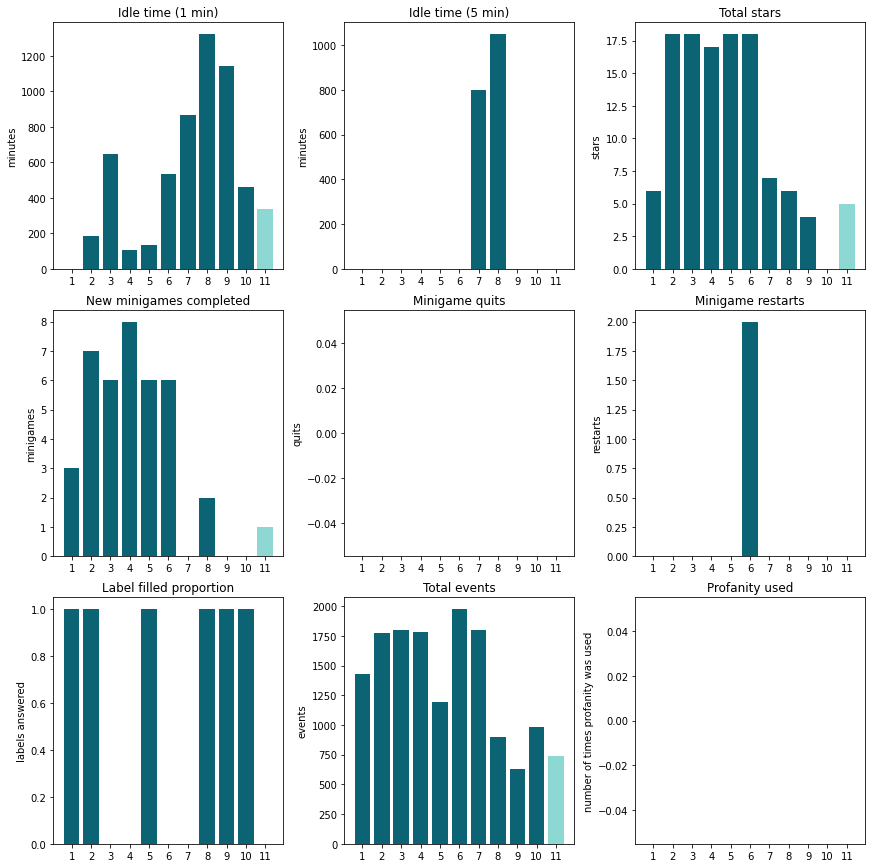

In [13]:
for player in players:
    #print(players[player])
    print("player_id: ",player,"\n\n",string_report(players[player]), sep="")
    plots(players[player])
    
    player_session_data = players[player].copy()
    for session in player_session_data:
        p = player_session_data[session]
        player_session_data[session] = sqldf("SELECT * FROM p LIMIT 1")
        for col in ["idle_time_60","idle_count_60","idle_time_300","idle_count_300","total_stars","new_minigames_completed","total_minigames_done_btn","total_quits","total_restarts","proportion_filled_labels","total_events","profanity_uses"]:
            if(col not in player_session_data[session].columns):
                    player_session_data[session][col] = 0
        if("profane_text" not in player_session_data[session].columns):
            player_session_data[session]["profane_text"] = ""
        player_session_data[session] = pd.Series(player_session_data[session].iloc[0])
    recent_keys = sorted(list(player_session_data.keys()), key=lambda x: x.strip()[-1], reverse=True)
    present = recent_keys[0]
    
    column_nice_format = {"total_stars":"Number of stars earned","total_minigames_done_btn":"Total number of minigames completed",
                         "new_minigames_completed":"Number of new minigames completed","total_events":"Total number of events performed",
                         "total_time":"Total time in session","total_quits":"Total times quitting a minigame",
                         "total_restarts":"Total times restarting a minigame", "idle_time_60":"Total time spent idling for more than 1 minute",
                         "idle_time_300":"Total time spent idling for more than 5 minutes","proportion_filled_labels":"Proportion of encountered labels that were filled"}
        
    print("Unusual activity\n================")
    for col in quartile_dict:
        try:
            if(player_session_data[present][col] < quartile_dict.get(col)[0] or player_session_data[present][col] > quartile_dict.get(col)[1]):
                print(f"!! - {column_nice_format.get(col)} was {player_session_data[present][col]} but is expected to be between {quartile_dict.get(col)[0]} and {quartile_dict.get(col)[1]}")
        except:
            print(f"Error with {col}, please check manually.")
    time_series(players[player][list(players[player].keys())[-1]])